# 处理链接为：https://zenodo.org/records/4399187 的数据

In [70]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

file_path = "/Users/taochen/coder/code/TOA/datasets/6611037/dataset.pkl"
# Extract dataset
dataset = pd.read_pickle(file_path)

ds = dataset

# 将 CIR 列中的 array 转换为 list
ds["CIR"] = ds["CIR"].apply(lambda x: x.tolist() if isinstance(x, np.ndarray) else x)
# 添加 TOA 列
ds["TOA"] = (ds["Range"] - ds["Error"]) / 3e8 * 1e9

# save ds
ds.to_csv(file_path.replace("pkl", "csv"))


# 处理链接为：https://log-a-tec.eu/uwb-ds.html 的数据

In [20]:
import os
import csv
import random
import pandas as pd

def load_uwb_csv(filename):
    rows = []
    with open(filename, "r") as f:
        reader = csv.reader(f)
        next(reader)  # 跳过第一行 v1.1
        header = next(reader)  # 读取列名行
        
        # 找到 CIR 列的位置
        cir_idx = header.index("CIR...")
        
        for row in reader:
            # 前面固定字段
            fixed = row[:cir_idx+1]  
            
            # CIR 部分：把后面所有的复数字符串转成真正的 complex
            cir_raw = row[cir_idx:]
            cir_values = []
            for val in cir_raw:
                if val.strip():  # 跳过空字符串
                    try:
                        cir = complex(val.replace(" ", ""))
                        cir_values.append(abs(cir))
                    except ValueError:
                        pass  # 有些异常值可以选择忽略
            
            # 组装结果：把 CIR 存成 list
            rows.append(fixed[:-1] + [cir_values])  # 把 CIR...列替换成 CIR list
    
    # 构造 DataFrame
    columns = header[:cir_idx] + ["CIR"]
    df = pd.DataFrame(rows, columns=columns)
    # 添加 TOA 列
    df["TOA"] = df["FP_INDEX"]
    # 丢弃TOA < 10的行，确保 TOA 列为数值型
    df["TOA"] = pd.to_numeric(df["TOA"], errors="coerce")
    df = df[df["TOA"] >= 10].reset_index(drop=True)
    # 截取TOA前后100对应CIR的点，然后随机插入CIR的其余位置，并保住总长度为300
    def process_cir_and_toa(cir, toa, window=100, total_len=300):
        toa = int(round(toa))
        cir = list(cir)
        left = max(0, toa - window)
        right = min(len(cir), toa + window)
        main = cir[left:right]
        others = cir[:left] + cir[right:]
        need = total_len - len(main)
        result = [0.0] * total_len
        if need > 0:
            if len(others) >= need:
                extra = random.sample(others, need)
            else:
                extra = others + [0.0] * (need - len(others))
            fill = main + extra
        else:
            fill = main[:total_len]
        start = random.randint(0, total_len - len(main))
        result[start:start+len(main)] = main
        fill_idx = 0
        for i in range(total_len):
            if result[i] == 0.0 and fill_idx < len(fill) - len(main):
                result[i] = fill[len(main) + fill_idx]
                fill_idx += 1
        new_toa = start + (toa - left) + 1
        return result, new_toa

    cir_toa_list = [process_cir_and_toa(row["CIR"], row["TOA"]) for _, row in df.iterrows()]
    df["CIR"] = [item[0] for item in cir_toa_list]
    df["TOA"] = [item[1] for item in cir_toa_list]

    return df

def process_and_save_all_csv(input_dir, output_dir):
    for root, _, files in os.walk(input_dir):
        for file in files:
            if file.endswith(".csv"):
                in_path = os.path.join(root, file)
                out_path = os.path.join(output_dir, os.path.basename(root), file)
                df = load_uwb_csv(in_path)
                os.makedirs(os.path.dirname(out_path), exist_ok=True)
                if not df.empty:
                    df.to_csv(out_path, index=False)
                    print(f"Processed and saved: {out_path}")

input_dir = "/Users/taochen/coder/code/TOA/datasets/data/office/measurements"
output_dir = "/Users/taochen/coder/code/TOA/datasets/data/office/industrial"


process_and_save_all_csv(input_dir, output_dir)


Processed and saved: /Users/taochen/coder/code/TOA/datasets/data/office/industrial/9.34_6.36_1.2/ch1_A4.csv
Processed and saved: /Users/taochen/coder/code/TOA/datasets/data/office/industrial/9.34_6.36_1.2/ch3_A1.csv
Processed and saved: /Users/taochen/coder/code/TOA/datasets/data/office/industrial/9.34_6.36_1.2/ch4_A8.csv
Processed and saved: /Users/taochen/coder/code/TOA/datasets/data/office/industrial/9.34_6.36_1.2/ch1_A5.csv
Processed and saved: /Users/taochen/coder/code/TOA/datasets/data/office/industrial/9.34_6.36_1.2/ch1_A7.csv
Processed and saved: /Users/taochen/coder/code/TOA/datasets/data/office/industrial/9.34_6.36_1.2/ch3_A2.csv
Processed and saved: /Users/taochen/coder/code/TOA/datasets/data/office/industrial/9.34_6.36_1.2/ch3_A3.csv
Processed and saved: /Users/taochen/coder/code/TOA/datasets/data/office/industrial/9.34_6.36_1.2/ch1_A6.csv
Processed and saved: /Users/taochen/coder/code/TOA/datasets/data/office/industrial/9.34_6.36_1.2/ch1_A2.csv
Processed and saved: /Users/

# 拆分数据集

In [15]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split

def merge_csvs_in_dir(input_dir):
    dfs = []
    for root, _, files in os.walk(input_dir):
        for file in files:
            if file.endswith('.csv'):
                df = pd.read_csv(os.path.join(root, file))
                dfs.append(df)
    if dfs:
        merged_df = pd.concat(dfs, ignore_index=True)
        return merged_df
    else:
        return None

def split_and_save_df(df, output_dir):
    train, temp = train_test_split(df, test_size=0.2, random_state=42)
    val, test = train_test_split(temp, test_size=0.5, random_state=42)
    os.makedirs(output_dir, exist_ok=True)
    train.to_csv(os.path.join(output_dir, f"train.csv"), index=False)
    val.to_csv(os.path.join(output_dir, f"val.csv"), index=False)
    test.to_csv(os.path.join(output_dir, f"test.csv"), index=False)

def split_csvs_in_dir(input_path, output_dir):
    if os.path.isfile(input_path) and input_path.endswith('.csv'):
        df = pd.read_csv(input_path)
        split_and_save_df(df, output_dir)
    else:
        merged_df = merge_csvs_in_dir(input_path)
        if merged_df is not None:
            split_and_save_df(merged_df, output_dir)

input_dir = "/Users/taochen/coder/code/TOA/datasets/data_process/"
output_dir = "/Users/taochen/coder/code/TOA/datasets/data_process/split"
# 用法示例
split_csvs_in_dir(input_dir, output_dir)

# 可视化数据

KeyboardInterrupt: 

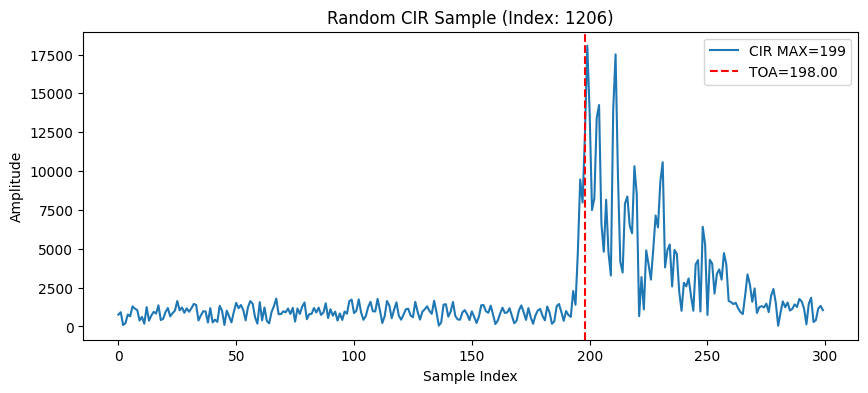

In [16]:
import random
import pandas as pd
import matplotlib.pyplot as plt

# file_path = "/Users/taochen/coder/code/TOA/datasets/6611037/dataset.csv"
file_path = "/Users/taochen/coder/code/TOA/datasets/data_process/split/test.csv"
output_dir = "/Users/taochen/coder/code/TOA/datasets/data_process/split/test_plots"
ds = pd.read_csv(file_path)

os.makedirs(output_dir, exist_ok=True)

for i, row in ds.iterrows():
    cir = eval(row["CIR"])
    toa = row["TOA"]
    plt.figure(figsize=(10, 4))
    plt.plot(cir, label=f"CIR MAX={list(cir).index(max(cir))}")
    plt.axvline(x=toa, color='r', linestyle='--', label=f'TOA={toa:.2f}')
    plt.title(f"Random CIR Sample (Index: {i})")
    plt.xlabel("Sample Index")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.savefig(f"{output_dir}/cir_{i}.png")
    plt.close()



In [3]:
import pandas as pd
import os
import matplotlib.pyplot as plt

def plot_cir_with_targets(csv_path, save_path):
    os.makedirs(save_path, exist_ok=True)
    df = pd.read_csv(csv_path)
    for idx, row in df.iterrows():
        cir = eval(row["CIR"])
        target = int(row["target"])
        prediction = int(row["prediction"])
        plt.figure(figsize=(10, 4))
        plt.plot(cir, label="CIR")
        plt.axvline(x=target, color='r', linestyle='--', label=f'Target={target}')
        plt.axvline(x=prediction, color='g', linestyle='--', label=f'Prediction={prediction}')
        plt.title(f"CIR Sample (Index: {idx})")
        plt.xlabel("Sample Index")
        plt.ylabel("Amplitude")
        plt.legend()
        plt.tight_layout()
        plt.savefig(f"{save_path}/cir_{idx}.png")
        plt.close()

# 用法示例
plot_cir_with_targets("results/toa_lstm_2/test_predictions.csv", "results/toa_lstm_2/test_predictions_plots")